In [1]:
import sys
import os

sys.path.append('/dfs/scratch0/vschen/metal')
os.environ['METALHOME'] = '/dfs/scratch0/vschen/metal'

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from metal.contrib.slicing.synthetics.geometric_synthetics import *

DATA_SEED = 2


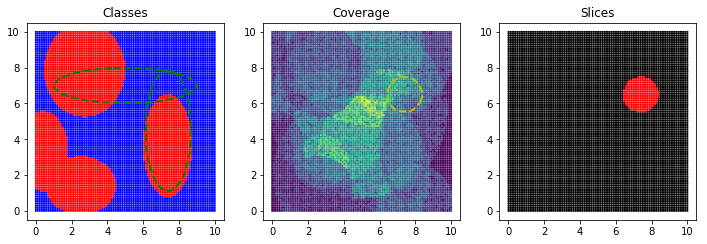

In [3]:
from scipy.sparse import csr_matrix

K = 2
M = 10
N = 10000
BATCHSIZE = 32
DATA_SEED = 2
print(f"DATA_SEED = {DATA_SEED}")

if DATA_SEED:
    random.seed(DATA_SEED)
    np.random.seed(DATA_SEED)
    _ = torch.manual_seed(DATA_SEED)
    
L_kwargs={
    "min_r": 1,
    "max_r": 5,
    "min_acc": 0.8,
    "max_acc": 1.0,
    "min_prop": 0.8,
    "max_prop": 0.9,
    "unipolar": False,
}
X_kwargs={"random": False}
Y_kwargs={"num_clusters": 4, "min_a": 1, "max_a": 3}
Z_kwargs={"num_slices": 4, "min_a": 1, "max_a": 2}

# Create background
canvas = Rectangle(0, 10, 0, 10)
X = create_points(canvas, N, **X_kwargs)
Y, label_regions = create_labels(X, K, **Y_kwargs)

L, lf_regions = create_lfs(X, Y, M, **L_kwargs)

# Create slice
Z = np.zeros(N)
slice_region = Circle(7.4,6.5,1)
Z = assign_y(X, Z, slice_region, 1)

# Create torso lf
torso_lf_region = Ellipse(7.4, 4.5, 1.3, 3.4)
props = (0.9, 0.9)
accs = (0.95, 0.2)
l = assign_l(X, Y, torso_lf_region, props, accs)
L = np.hstack((L, l.reshape(-1,1)))

# Create head lf
head_lf_region = Ellipse(5, 7, 4, 1.0)
props = (0.9, 0.9)
accs = (0.95, 0.2)
l = assign_l(X, Y, head_lf_region, props, accs)
L = np.hstack((L, l.reshape(-1,1)))

# Plot
fig_size = 12
fig, axs = plt.subplots(1, 3, figsize=(fig_size, fig_size))
plt.sca(axs[0])
plot_labels(X, Y)
plot_region(X, slice_region, color='y')
plot_region(X, torso_lf_region, color='g')
plot_region(X, head_lf_region, color='g')

        
plt.sca(axs[1])
plot_coverage(X, L)
plot_region(X, slice_region, color='y')
plt.sca(axs[2])
plot_slices(X, Z)

# Standardize formats
L = csr_matrix(L)
X = torch.Tensor(X)

In [4]:
from metal.utils import split_data

Ls, Xs, Ys, Zs = split_data(L, X, Y, Z, splits=[0.5, 0.25, 0.25], shuffle=True)

In [5]:
from metal.analysis import lf_summary
lf_summary(L, Y)

,Polarity,Coverage,Overlaps,Conflicts,Correct,Incorrect,Emp. Acc.
0,"[1, 2]",0.0628,0.0624,0.0184,606,22,0.964968
1,"[1, 2]",0.1994,0.1984,0.0689,1708,286,0.856570
2,"[1, 2]",0.0532,0.0532,0.0394,440,92,0.827068
3,"[1, 2]",0.0689,0.0684,0.0230,616,73,0.894049
4,"[1, 2]",0.6079,0.5616,0.1737,5672,407,0.933048
5,"[1, 2]",0.1549,0.1296,0.0241,1375,174,0.887669
6,"[1, 2]",0.2344,0.2336,0.0766,2305,39,0.983362
7,"[1, 2]",0.4003,0.3220,0.0980,3341,662,0.834624
8,"[1, 2]",0.3695,0.3283,0.1169,3363,332,0.910149
9,"[1, 2]",0.0809,0.0507,0.0131,760,49,0.939431


In [6]:
from metal.contrib.backends.snorkel_gm_wrapper import SnorkelLabelModel

label_model = SnorkelLabelModel()
label_model.train_model(Ls[0])

from metal.metrics import accuracy_score

Y_train_ps = label_model.predict_proba(Ls[0])
Ys[0] = Y_train_ps

Y_dev_ps = label_model.predict_proba(Ls[0])
Y_dev_p = label_model.predict(Ls[1])
accuracy_score(Ys[1], Y_dev_p)

0.896

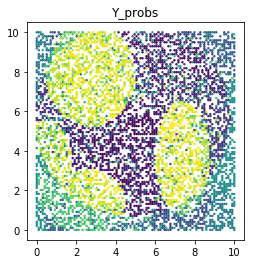

In [7]:
plot_probs(Xs[0], Y_train_ps[:,0], point_size=2)

In [8]:
import torch
from torch.utils.data import DataLoader
from metal.utils import SlicingDataset

Ls_tensors = [torch.Tensor(np.asarray(L.todense())) for L in Ls]

train_loader = DataLoader(
    SlicingDataset(Ls_tensors[0], Xs[0], Y_train_ps, Zs[0]),
    batch_size=BATCHSIZE,
    shuffle=True
)

dev_loader = DataLoader(SlicingDataset(Ls_tensors[1], Xs[1], Ys[1], Zs[1]))
test_loader = DataLoader(SlicingDataset(Ls_tensors[1], Xs[2], Ys[2], Zs[2]))

In [9]:
import os
from metal.contrib.slicing.metrics import calc_slice_acc, calc_heads_acc

# MODEL_SEED = np.random.randint(1e6)
MODEL_SEED = 123
print(f"model_seed: {MODEL_SEED}")

RUN_NAME = f"{DATA_SEED}_{MODEL_SEED}_SM"

em_config = {
    "layer_out_dims": [2, 20, 20, 2],
    "verbose": False,
#     "seed": MODEL_SEED,
}

sm_config = {
    "L_weight": 0.1,
    "Y_off_weight": 0.1,
    "vanilla": False,
    "online_head": True,
    "indicator": False,
    "mask_abstains": True,
    "verbose": True,
}

base_em_config = {
    "vanilla": True,
    "online_head": False,
    "indicator": False,
    "mask_abstains": False,
    "verbose": True,
}

train_kwargs = {
    "n_epochs": 30,
    "lr": 0.01,
    "l2": 1e-5,
    "log_unit": "epochs",
#     "log_train_metrics_func": None,
#     "log_train_metrics": ["loss"],
    "log_train_every": 1,
    "log_valid_every": 1,
    "log_valid_metrics_func": [calc_slice_acc], # calc_heads_acc],
#     "log_valid_metrics": ["L_acc", "Y_off_acc", "Y_on_acc"],
    "checkpoint": True,
#     "checkpoint_metric": "Y_on_acc",
    "writer": "tensorboard",
    "log_dir": f"{os.environ['METALHOME']}/tensorboard/",
    "run_name": RUN_NAME,
}

model_seed: 123


In [10]:
def plot_predictions(model, test_loader):
    Y_p, Y = model._get_predictions(test_loader)
    L_test, X_test, Y_test, Z_test = test_loader.dataset.data
    X_test = X_test.numpy()
    
    fig_size = 12
    fig, axs = plt.subplots(1, 3, figsize=(fig_size, fig_size))
    plt.sca(axs[0])
    plot_labels(X_test, Y_test)
    plot_region(X_test, slice_region, color='c')
    plot_region(X_test, torso_lf_region, color='g')
    plot_region(X_test, head_lf_region, color='g')
    plt.sca(axs[1])
    plot_slices(X_test, Z_test)
    
    plt.sca(axs[2])
    plot_labels(X_test, Y_p, title='Predictions')
    plot_region(X_test, slice_region, color='g')

---------- 0 ----------
Overriding options to create vanilla EndModel.
Resetting base model parameters
SliceMaster(
  (body): Sequential(
    (0): IdentityModule()
    (1): Sequential(
      (0): Linear(in_features=2, out_features=20, bias=True)
      (1): ReLU()
    )
    (2): Sequential(
      (0): Linear(in_features=20, out_features=20, bias=True)
      (1): ReLU()
    )
  )
  (Y_head_off): Linear(in_features=20, out_features=1, bias=True)
  (Y_criteria): BCEWithLogitsLoss()
)



/dfs/scratch0/vschen/metal/metal/classifier.py:770: UserWarning: Slice accuracies currently only work for valid set!
  warnings.warn(msg)


[1 epo]: TRAIN:[loss=20.905] VALID:[slice_1=0.653, accuracy=0.722]
Saving model at iteration 1 with best score 0.722
[2 epo]: TRAIN:[loss=20.208] VALID:[slice_1=0.653, accuracy=0.756]
Saving model at iteration 2 with best score 0.756
[3 epo]: TRAIN:[loss=20.115] VALID:[slice_1=0.653, accuracy=0.736]
[4 epo]: TRAIN:[loss=20.116] VALID:[slice_1=0.653, accuracy=0.757]
Saving model at iteration 4 with best score 0.757
[5 epo]: TRAIN:[loss=20.101] VALID:[slice_1=0.653, accuracy=0.757]
[6 epo]: TRAIN:[loss=20.031] VALID:[slice_1=0.653, accuracy=0.749]
[7 epo]: TRAIN:[loss=20.033] VALID:[slice_1=0.653, accuracy=0.772]
Saving model at iteration 7 with best score 0.772
[8 epo]: TRAIN:[loss=20.057] VALID:[slice_1=0.653, accuracy=0.746]
[9 epo]: TRAIN:[loss=20.029] VALID:[slice_1=0.653, accuracy=0.770]
[10 epo]: TRAIN:[loss=19.954] VALID:[slice_1=0.653, accuracy=0.760]
[11 epo]: TRAIN:[loss=19.937] VALID:[slice_1=0.720, accuracy=0.752]
[12 epo]: TRAIN:[loss=19.728] VALID:[slice_1=0.653, accuracy=

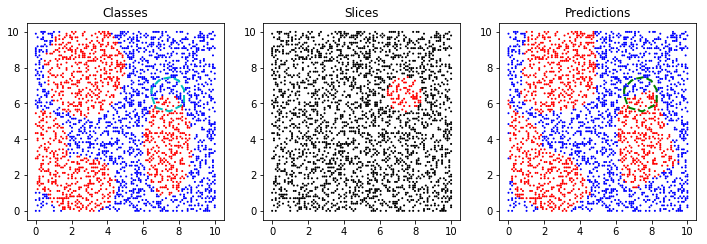

Resetting base model parameters
SliceMaster(
  (body): Sequential(
    (0): IdentityModule()
    (1): Sequential(
      (0): Linear(in_features=2, out_features=20, bias=True)
      (1): ReLU()
    )
    (2): Sequential(
      (0): Linear(in_features=20, out_features=20, bias=True)
      (1): ReLU()
    )
  )
  (L_head): Linear(in_features=20, out_features=12, bias=False)
  (L_criteria): BCEWithLogitsLoss()
  (Y_head_off): Linear(in_features=20, out_features=1, bias=True)
  (Y_criteria): BCEWithLogitsLoss()
  (Y_head_on): Linear(in_features=20, out_features=1, bias=True)
)

[1 epo]: TRAIN:[loss=18.649] VALID:[slice_1=0.653, accuracy=0.764]
Saving model at iteration 1 with best score 0.764
[2 epo]: TRAIN:[loss=18.023] VALID:[slice_1=0.653, accuracy=0.750]
[3 epo]: TRAIN:[loss=17.778] VALID:[slice_1=0.653, accuracy=0.778]
Saving model at iteration 3 with best score 0.778
[4 epo]: TRAIN:[loss=17.721] VALID:[slice_1=0.693, accuracy=0.755]
[5 epo]: TRAIN:[loss=17.603] VALID:[slice_1=0.707, a

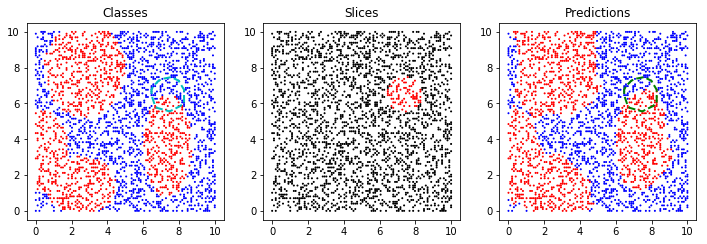

---------- 1 ----------
Overriding options to create vanilla EndModel.
Resetting base model parameters
SliceMaster(
  (body): Sequential(
    (0): IdentityModule()
    (1): Sequential(
      (0): Linear(in_features=2, out_features=20, bias=True)
      (1): ReLU()
    )
    (2): Sequential(
      (0): Linear(in_features=20, out_features=20, bias=True)
      (1): ReLU()
    )
  )
  (Y_head_off): Linear(in_features=20, out_features=1, bias=True)
  (Y_criteria): BCEWithLogitsLoss()
)

[1 epo]: TRAIN:[loss=21.333] VALID:[slice_1=0.653, accuracy=0.703]
Saving model at iteration 1 with best score 0.703
[2 epo]: TRAIN:[loss=20.579] VALID:[slice_1=0.653, accuracy=0.762]
Saving model at iteration 2 with best score 0.762
[3 epo]: TRAIN:[loss=20.065] VALID:[slice_1=0.653, accuracy=0.773]
Saving model at iteration 3 with best score 0.773
[4 epo]: TRAIN:[loss=19.927] VALID:[slice_1=0.653, accuracy=0.770]
[5 epo]: TRAIN:[loss=19.716] VALID:[slice_1=0.653, accuracy=0.759]
[6 epo]: TRAIN:[loss=19.569] 

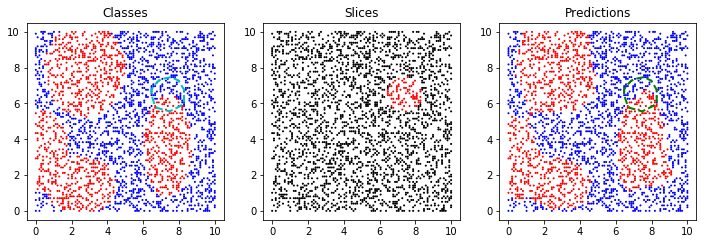

Resetting base model parameters
SliceMaster(
  (body): Sequential(
    (0): IdentityModule()
    (1): Sequential(
      (0): Linear(in_features=2, out_features=20, bias=True)
      (1): ReLU()
    )
    (2): Sequential(
      (0): Linear(in_features=20, out_features=20, bias=True)
      (1): ReLU()
    )
  )
  (L_head): Linear(in_features=20, out_features=12, bias=False)
  (L_criteria): BCEWithLogitsLoss()
  (Y_head_off): Linear(in_features=20, out_features=1, bias=True)
  (Y_criteria): BCEWithLogitsLoss()
  (Y_head_on): Linear(in_features=20, out_features=1, bias=True)
)

[1 epo]: TRAIN:[loss=18.977] VALID:[slice_1=0.653, accuracy=0.734]
Saving model at iteration 1 with best score 0.734
[2 epo]: TRAIN:[loss=18.474] VALID:[slice_1=0.720, accuracy=0.734]
Saving model at iteration 2 with best score 0.734
[3 epo]: TRAIN:[loss=18.298] VALID:[slice_1=0.653, accuracy=0.740]
Saving model at iteration 3 with best score 0.740
[4 epo]: TRAIN:[loss=18.214] VALID:[slice_1=0.800, accuracy=0.729]
[5

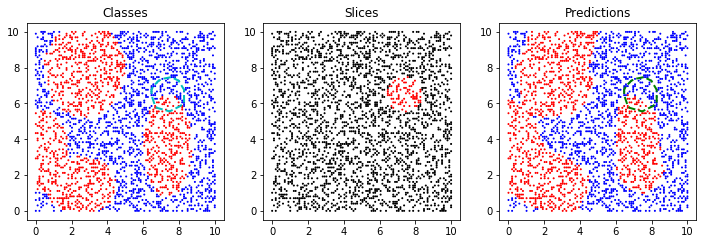

---------- 2 ----------
Overriding options to create vanilla EndModel.
Resetting base model parameters
SliceMaster(
  (body): Sequential(
    (0): IdentityModule()
    (1): Sequential(
      (0): Linear(in_features=2, out_features=20, bias=True)
      (1): ReLU()
    )
    (2): Sequential(
      (0): Linear(in_features=20, out_features=20, bias=True)
      (1): ReLU()
    )
  )
  (Y_head_off): Linear(in_features=20, out_features=1, bias=True)
  (Y_criteria): BCEWithLogitsLoss()
)

[1 epo]: TRAIN:[loss=21.645] VALID:[slice_1=0.653, accuracy=0.686]
Saving model at iteration 1 with best score 0.686
[2 epo]: TRAIN:[loss=20.836] VALID:[slice_1=0.653, accuracy=0.694]
Saving model at iteration 2 with best score 0.694
[3 epo]: TRAIN:[loss=20.585] VALID:[slice_1=0.653, accuracy=0.705]
Saving model at iteration 3 with best score 0.705
[4 epo]: TRAIN:[loss=20.277] VALID:[slice_1=0.653, accuracy=0.761]
Saving model at iteration 4 with best score 0.761
[5 epo]: TRAIN:[loss=20.039] VALID:[slice_1=0.

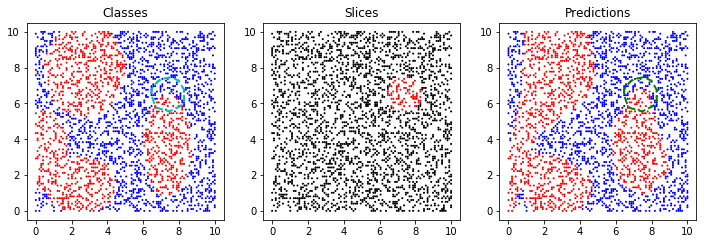

Resetting base model parameters
SliceMaster(
  (body): Sequential(
    (0): IdentityModule()
    (1): Sequential(
      (0): Linear(in_features=2, out_features=20, bias=True)
      (1): ReLU()
    )
    (2): Sequential(
      (0): Linear(in_features=20, out_features=20, bias=True)
      (1): ReLU()
    )
  )
  (L_head): Linear(in_features=20, out_features=12, bias=False)
  (L_criteria): BCEWithLogitsLoss()
  (Y_head_off): Linear(in_features=20, out_features=1, bias=True)
  (Y_criteria): BCEWithLogitsLoss()
  (Y_head_on): Linear(in_features=20, out_features=1, bias=True)
)

[1 epo]: TRAIN:[loss=19.003] VALID:[slice_1=0.653, accuracy=0.745]
Saving model at iteration 1 with best score 0.745
[2 epo]: TRAIN:[loss=18.184] VALID:[slice_1=0.653, accuracy=0.758]
Saving model at iteration 2 with best score 0.758
[3 epo]: TRAIN:[loss=18.168] VALID:[slice_1=0.693, accuracy=0.751]
[4 epo]: TRAIN:[loss=18.074] VALID:[slice_1=0.653, accuracy=0.768]
Saving model at iteration 4 with best score 0.768
[5

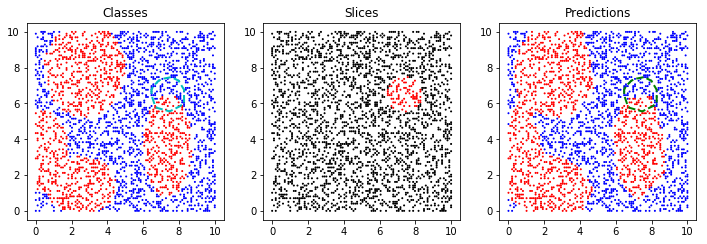

---------- 3 ----------
Overriding options to create vanilla EndModel.
Resetting base model parameters
SliceMaster(
  (body): Sequential(
    (0): IdentityModule()
    (1): Sequential(
      (0): Linear(in_features=2, out_features=20, bias=True)
      (1): ReLU()
    )
    (2): Sequential(
      (0): Linear(in_features=20, out_features=20, bias=True)
      (1): ReLU()
    )
  )
  (Y_head_off): Linear(in_features=20, out_features=1, bias=True)
  (Y_criteria): BCEWithLogitsLoss()
)

[1 epo]: TRAIN:[loss=20.736] VALID:[slice_1=0.653, accuracy=0.708]
Saving model at iteration 1 with best score 0.708
[2 epo]: TRAIN:[loss=20.198] VALID:[slice_1=0.653, accuracy=0.743]
Saving model at iteration 2 with best score 0.743
[3 epo]: TRAIN:[loss=20.136] VALID:[slice_1=0.653, accuracy=0.770]
Saving model at iteration 3 with best score 0.770
[4 epo]: TRAIN:[loss=19.894] VALID:[slice_1=0.653, accuracy=0.746]
[5 epo]: TRAIN:[loss=19.763] VALID:[slice_1=0.653, accuracy=0.778]
Saving model at iteration 5 w

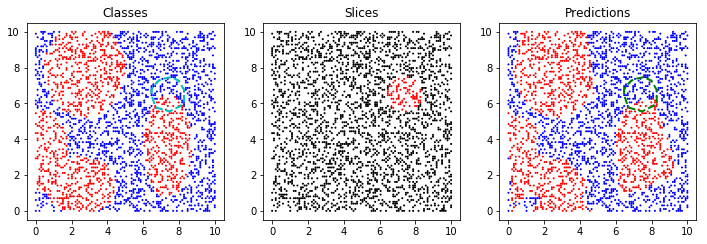

Resetting base model parameters
SliceMaster(
  (body): Sequential(
    (0): IdentityModule()
    (1): Sequential(
      (0): Linear(in_features=2, out_features=20, bias=True)
      (1): ReLU()
    )
    (2): Sequential(
      (0): Linear(in_features=20, out_features=20, bias=True)
      (1): ReLU()
    )
  )
  (L_head): Linear(in_features=20, out_features=12, bias=False)
  (L_criteria): BCEWithLogitsLoss()
  (Y_head_off): Linear(in_features=20, out_features=1, bias=True)
  (Y_criteria): BCEWithLogitsLoss()
  (Y_head_on): Linear(in_features=20, out_features=1, bias=True)
)

[1 epo]: TRAIN:[loss=18.809] VALID:[slice_1=0.720, accuracy=0.736]
Saving model at iteration 1 with best score 0.736
[2 epo]: TRAIN:[loss=18.230] VALID:[slice_1=0.653, accuracy=0.757]
Saving model at iteration 2 with best score 0.757
[3 epo]: TRAIN:[loss=18.097] VALID:[slice_1=0.653, accuracy=0.751]
[4 epo]: TRAIN:[loss=18.040] VALID:[slice_1=0.653, accuracy=0.755]
[5 epo]: TRAIN:[loss=17.952] VALID:[slice_1=0.653, a

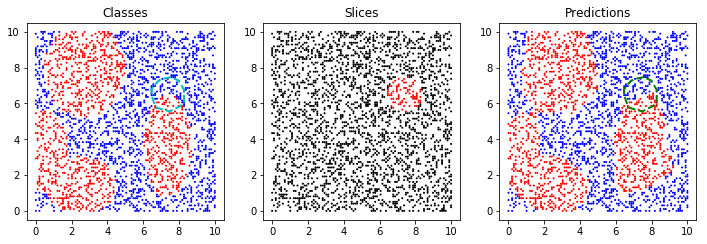

---------- 4 ----------
Overriding options to create vanilla EndModel.
Resetting base model parameters
SliceMaster(
  (body): Sequential(
    (0): IdentityModule()
    (1): Sequential(
      (0): Linear(in_features=2, out_features=20, bias=True)
      (1): ReLU()
    )
    (2): Sequential(
      (0): Linear(in_features=20, out_features=20, bias=True)
      (1): ReLU()
    )
  )
  (Y_head_off): Linear(in_features=20, out_features=1, bias=True)
  (Y_criteria): BCEWithLogitsLoss()
)

[1 epo]: TRAIN:[loss=20.727] VALID:[slice_1=0.653, accuracy=0.688]
Saving model at iteration 1 with best score 0.688
[2 epo]: TRAIN:[loss=20.104] VALID:[slice_1=0.653, accuracy=0.769]
Saving model at iteration 2 with best score 0.769
[3 epo]: TRAIN:[loss=19.935] VALID:[slice_1=0.653, accuracy=0.785]
Saving model at iteration 3 with best score 0.785
[4 epo]: TRAIN:[loss=19.758] VALID:[slice_1=0.653, accuracy=0.776]
[5 epo]: TRAIN:[loss=19.356] VALID:[slice_1=0.653, accuracy=0.794]
Saving model at iteration 5 w

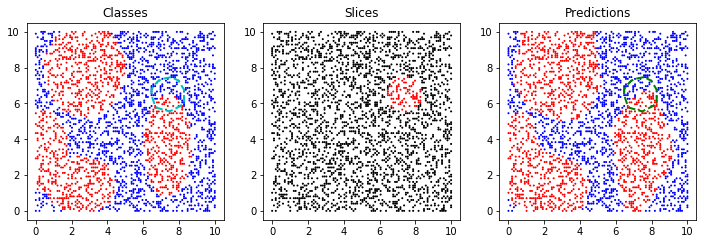

Resetting base model parameters
SliceMaster(
  (body): Sequential(
    (0): IdentityModule()
    (1): Sequential(
      (0): Linear(in_features=2, out_features=20, bias=True)
      (1): ReLU()
    )
    (2): Sequential(
      (0): Linear(in_features=20, out_features=20, bias=True)
      (1): ReLU()
    )
  )
  (L_head): Linear(in_features=20, out_features=12, bias=False)
  (L_criteria): BCEWithLogitsLoss()
  (Y_head_off): Linear(in_features=20, out_features=1, bias=True)
  (Y_criteria): BCEWithLogitsLoss()
  (Y_head_on): Linear(in_features=20, out_features=1, bias=True)
)

[1 epo]: TRAIN:[loss=18.885] VALID:[slice_1=0.653, accuracy=0.681]
Saving model at iteration 1 with best score 0.681
[2 epo]: TRAIN:[loss=18.155] VALID:[slice_1=0.667, accuracy=0.751]
Saving model at iteration 2 with best score 0.751
[3 epo]: TRAIN:[loss=18.022] VALID:[slice_1=0.653, accuracy=0.777]
Saving model at iteration 3 with best score 0.777
[4 epo]: TRAIN:[loss=17.884] VALID:[slice_1=0.693, accuracy=0.756]
[5

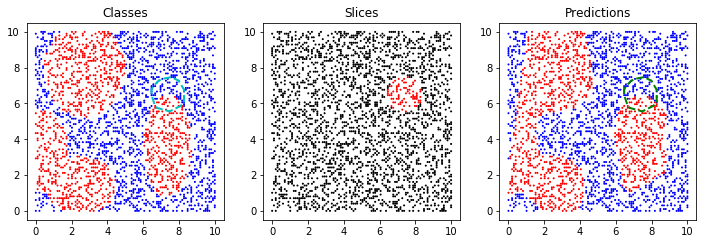

In [11]:
from collections import defaultdict
from metal.end_model import EndModel
from metal.contrib.slicing.slice_model import SliceMaster
from metal.contrib.slicing.experiment_utils import eval_model

model_configs = {
    'EM': base_em_config,
    'SM': sm_config
}
NUM_TRIALS = 5
history = defaultdict(list)
for trial in range(NUM_TRIALS):
    print ("-"*10, trial, "-"*10)
    for model_name, model_config in model_configs.items():
        base_model = EndModel(**em_config)
        model = SliceMaster(base_model, m=Ls[0].shape[1], **model_config)
        model.train_model(train_loader, valid_data=dev_loader, **train_kwargs)
        results = eval_model(model, test_loader, verbose=False)
        history[model_name].append(results)
        print (f"{model_name} Predictions")
        plot_predictions(model, test_loader)
        plt.show()

In [14]:
SLICE_NAME = 'slice_1'
for model_name, scores in history.items():
    print(model_name)
    for s in scores:
        print(s[SLICE_NAME]['accuracy'])

EM
0.7848101265822784
0.7974683544303798
0.8607594936708861
0.810126582278481
0.7848101265822784
SM
0.7215189873417721
0.8860759493670886
0.9367088607594937
0.7974683544303798
0.9493670886075949


In [15]:
from metal.contrib.slicing.experiment_utils import parse_history

print(f"Average (n={NUM_TRIALS}):")
df = parse_history(history, 1)
df

Average (n=5):


,EM,SM
all,0.923920,0.934080
slice_0,0.927716,0.936555
slice_1,0.807595,0.858228
slice_avg,0.867655,0.897391
